# Notebook Setup

In [ ]:
# Install necessary libraries (if not already installed)
!pip install -q pandas
!pip install xgboost lightgbm

In [10]:
# Import required libraries
import pandas as pd
from google.colab import drive, files
import os

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from collections import Counter

# Upload of Dataset

In [4]:
def upload_from_local():
    print("Please upload your CSV file:")
    uploaded = files.upload()
    file_name = next(iter(uploaded))
    return pd.read_csv(file_name)

# Upload file directly from local machine
df = upload_from_local()

# Display dataset preview
print("\nDataset preview:")
print(df.head())

Please upload your CSV file:


Saving loan.csv to loan.csv

Dataset preview:
     customer_id     loan_id      loan_type  loan_amount  interest_rate  \
0  CUST-00004912  LN00004170       Car Loan        16795       0.051852   
1  CUST-00004194  LN00002413  Personal Loan         1860       0.089296   
2  CUST-00003610  LN00000024  Personal Loan        77820       0.070470   
3  CUST-00001895  LN00001742       Car Loan        55886       0.062155   
4  CUST-00003782  LN00003161      Home Loan         7265       0.070635   

   loan_term employment_type income_level  credit_score  gender  \
0         15   Self-employed       Medium           833    Male   
1         56       Full-time       Medium           776  Female   
2         51       Full-time          Low           697    Male   
3         30       Full-time          Low           795  Female   
4         48       Part-time          Low           519  Female   

  marital_status education_level application_date approval_date  \
0         Single          Master 

# Data Wrangling

In [5]:
# Clean and Engineer Features
df_clean = df.drop(columns=['customer_id', 'loan_id'])

# Convert dates
date_columns = ['application_date', 'approval_date', 'disbursement_date', 'due_date']
for col in date_columns:
    df_clean[col] = pd.to_datetime(df_clean[col], format='%d-%m-%Y')

# Feature engineering
df_clean['processing_days'] = (df_clean['approval_date'] - df_clean['application_date']).dt.days
df_clean['disbursement_delay'] = (df_clean['disbursement_date'] - df_clean['approval_date']).dt.days
df_clean['loan_duration_days'] = (df_clean['due_date'] - df_clean['disbursement_date']).dt.days

df_clean.drop(columns=date_columns, inplace=True)

## Data Information

In [6]:
df_clean.head()

,loan_type,loan_amount,interest_rate,loan_term,employment_type,income_level,credit_score,gender,marital_status,education_level,default_status,processing_days,disbursement_delay,loan_duration_days
0,Car Loan,16795,0.051852,15,Self-employed,Medium,833,Male,Single,Master,False,18,1,112
1,Personal Loan,1860,0.089296,56,Full-time,Medium,776,Female,Married,Bachelor,False,1,12,83
2,Personal Loan,77820,0.070470,51,Full-time,Low,697,Male,Divorced,High School,False,3,9,89
3,Car Loan,55886,0.062155,30,Full-time,Low,795,Female,Married,PhD,False,14,3,167
4,Home Loan,7265,0.070635,48,Part-time,Low,519,Female,Married,High School,False,5,4,109


In [7]:
df_clean.shape[0]

5000

# Categorical Features

In [8]:
categorical_cols = df_clean.select_dtypes(include='object').columns
le = LabelEncoder()
for col in categorical_cols:
    df_clean[col] = le.fit_transform(df_clean[col])

# Splitting of data

In [11]:
# Split and Scale
X = df_clean.drop('default_status', axis=1)
y = df_clean['default_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Models

In [12]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "LightGBM": LGBMClassifier(random_state=42)
}

## Setup and Model Training

In [14]:
summary_table = []
model_outputs = {}

# Determine defaulter class (minority class)
minority_class = min(Counter(y_test).items(), key=lambda x: x[1])[0]

# Train models and store predictions
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]
    model_outputs[name] = (y_pred, y_proba)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [06:11:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 795, number of negative: 3205
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1031
[LightGBM] [Info] Number of data points in the train set: 4000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.198750 -> initscore=-1.394125
[LightGBM] [Info] Start training from score -1.394125


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


## Model Visualization

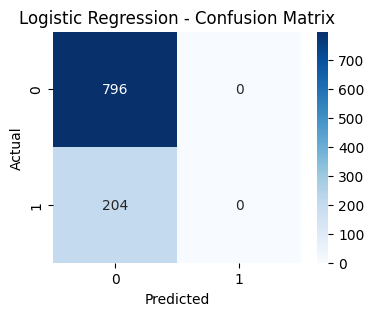

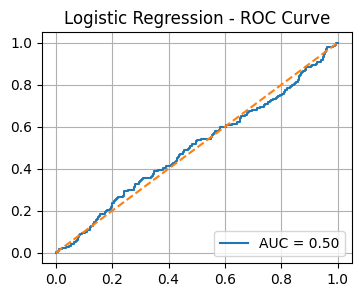

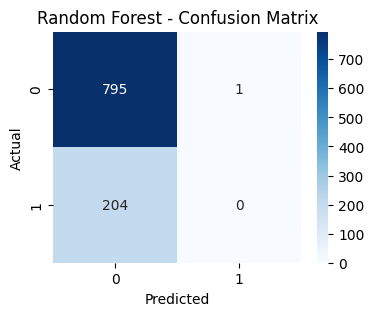

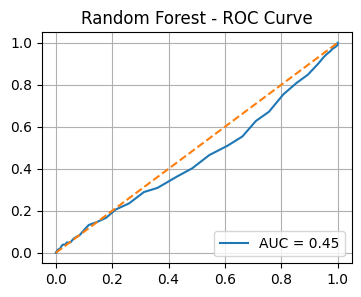

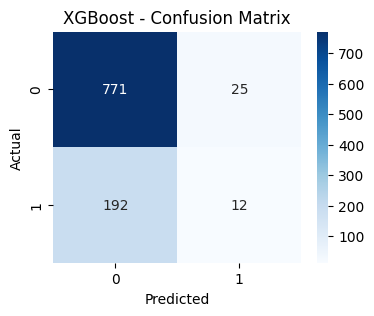

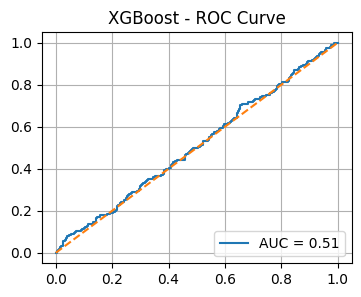

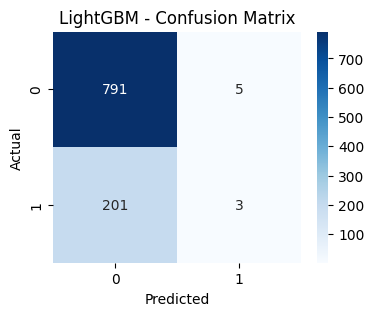

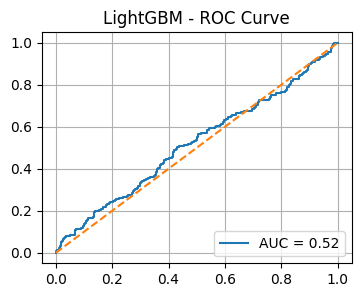

In [15]:
# Generate confusion matrices and ROC curves
for name, (y_pred, y_proba) in model_outputs.items():
    # Confusion Matrix
    plt.figure(figsize=(4, 3))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.title(f'{name} - ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

## Classification Reports

In [16]:
for name, (y_pred, _) in model_outputs.items():
    print(f"\n📋 Classification Report for {name}:")
    print(classification_report(y_test, y_pred))
    print("\n" + "="*60 + "\n")


📋 Classification Report for Logistic Regression:
              precision    recall  f1-score   support

       False       0.80      1.00      0.89       796
        True       0.00      0.00      0.00       204

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.44      1000
weighted avg       0.63      0.80      0.71      1000




📋 Classification Report for Random Forest:
              precision    recall  f1-score   support

       False       0.80      1.00      0.89       796
        True       0.00      0.00      0.00       204

    accuracy                           0.80      1000
   macro avg       0.40      0.50      0.44      1000
weighted avg       0.63      0.80      0.71      1000




📋 Classification Report for XGBoost:
              precision    recall  f1-score   support

       False       0.80      0.97      0.88       796
        True       0.32      0.06      0.10       204

    accuracy                           0.78   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Metrics Compilation

In [17]:
for name, (y_pred, y_proba) in model_outputs.items():
    report = classification_report(y_test, y_pred, output_dict=True)
    defaulter_key = str(minority_class) if str(minority_class) in report else minority_class

    summary_table.append({
        "Model": name,
        "Accuracy": report['accuracy'],
        "Precision (Defaulter)": report[defaulter_key]['precision'],
        "Recall (Defaulter)": report[defaulter_key]['recall'],
        "F1 Score (Defaulter)": report[defaulter_key]['f1-score'],
        "ROC AUC": auc(roc_curve(y_test, y_proba)[0], roc_curve(y_test, y_proba)[1])
    })

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Final Summary

In [19]:
summary_df = pd.DataFrame(summary_table)
print("\n Final Model Comparison:")
display(summary_df.style.background_gradient(cmap='Blues', subset=summary_df.columns[1:]))


 Final Model Comparison:


,Model,Accuracy,Precision (Defaulter),Recall (Defaulter),F1 Score (Defaulter),ROC AUC
0,Logistic Regression,0.796000,0.000000,0.000000,0.000000,0.500376
1,Random Forest,0.795000,0.000000,0.000000,0.000000,0.453613
2,XGBoost,0.783000,0.324324,0.058824,0.099585,0.509946
3,LightGBM,0.794000,0.375000,0.014706,0.028302,0.518142


Although Logistic Regression and Random Forest showed high accuracy (~79-80%), they completely failed to identify defaulters, achieving 0 precision, recall, and F1 score for that class. In contrast, XGBoost and LightGBM demonstrated better sensitivity to defaulters, especially LightGBM with a defaulter precision of 37.5%, albeit with very low recall. These results highlight the limitations of accuracy in imbalanced datasets and the need for techniques such as resampling or cost-sensitive learning to improve detection of minority outcomes like default.

# Feature Importance Comparison

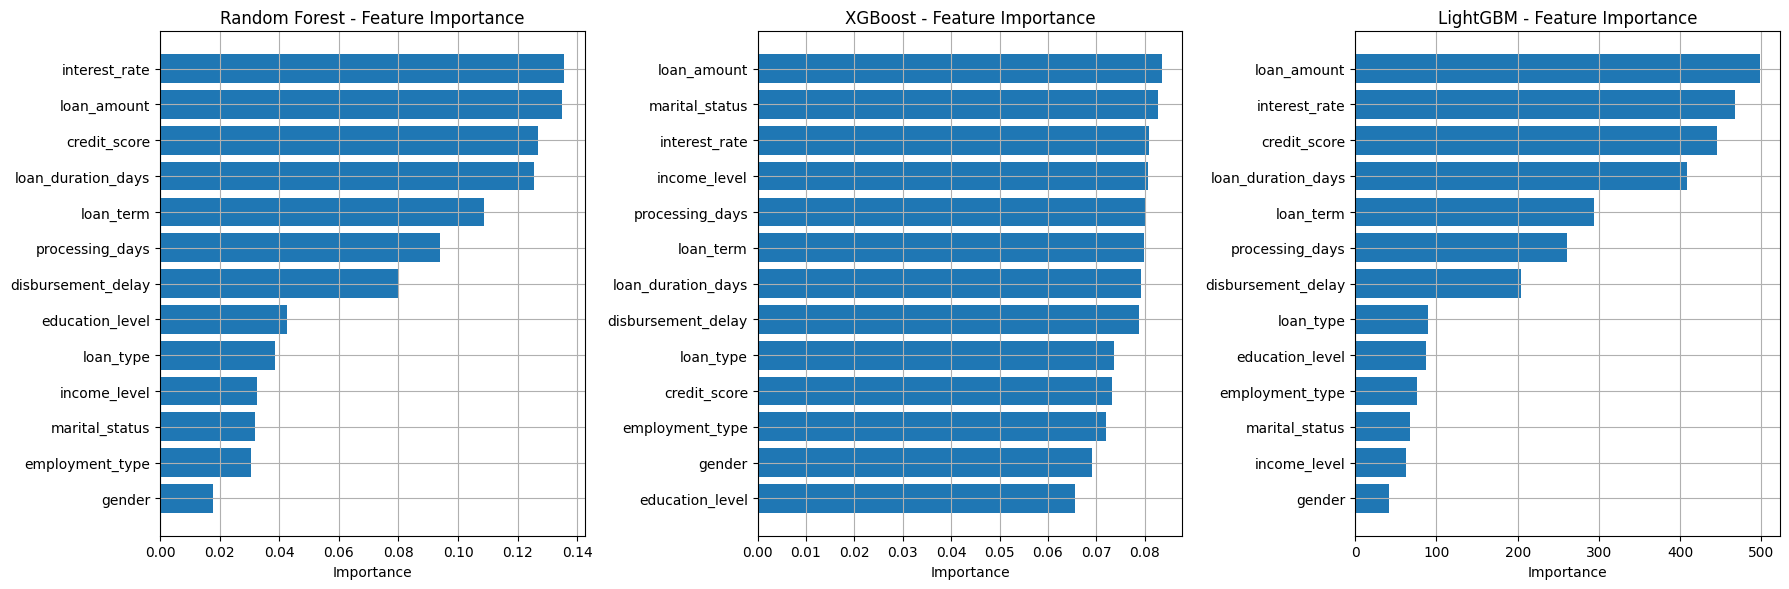

In [21]:
# Set up the figure and subplots
plt.figure(figsize=(18, 6))  # Wider figure to accommodate 3 plots

# Create 3 subplots side by side
for i, name in enumerate(["Random Forest", "XGBoost", "LightGBM"]):
    model = models[name]
    importance = model.feature_importances_
    features = X.columns
    sorted_idx = importance.argsort()

    # Create subplot in position i+1 (1, 2, 3)
    plt.subplot(1, 3, i+1)  # 1 row, 3 columns, current index
    plt.barh(features[sorted_idx], importance[sorted_idx])
    plt.title(f"{name} - Feature Importance")
    plt.xlabel("Importance")
    plt.grid(True)
    plt.tight_layout()

plt.show()

The graph and table together highlight the challenges of working with imbalanced datasets. While all models show strong overall accuracy (~79–80%), this masks the critical failure to identify defaulters in most models. Logistic Regression and Random Forest never predicted a single defaulter correctly, while XGBoost and LightGBM offered some improvement—especially in precision—but still had very low recall and AUC. This clearly shows that the current models are not yet suitable for real-world credit risk prediction. Future work should focus on class balancing (via SMOTE or class weights), threshold adjustment, or ensemble tuning to improve minority class detection.

In [33]:
# Function to get top N features from a model
def get_top_features(model, feature_names, top_n=10):
    importance = model.feature_importances_
    sorted_idx = importance.argsort()[::-1]
    top_features = [(feature_names[i], importance[i]) for i in sorted_idx[:top_n]]
    return pd.DataFrame(top_features, columns=['Feature', 'Importance'])

# Create a comparison table of top features
top_features_comparison = {}
for name in ["Random Forest", "XGBoost", "LightGBM"]:
    top_features_comparison[name] = get_top_features(models[name], X.columns)

# Display results
pd.concat([
    top_features_comparison["Random Forest"].rename(columns={'Importance': 'RF Importance'}),
    top_features_comparison["XGBoost"][['Feature', 'Importance']].rename(columns={'Importance': 'XGB Importance'}),
    top_features_comparison["LightGBM"][['Feature', 'Importance']].rename(columns={'Importance': 'LGBM Importance'})
], axis=1)

,Feature,RF Importance,Feature,XGB Importance,Feature,LGBM Importance
0,interest_rate,0.135710,loan_amount,0.083613,loan_amount,498
1,loan_amount,0.134766,marital_status,0.082836,interest_rate,467
2,credit_score,0.126822,interest_rate,0.080959,credit_score,445
3,loan_duration_days,0.125402,income_level,0.080793,loan_duration_days,408
4,loan_term,0.108873,processing_days,0.080340,loan_term,294
5,processing_days,0.093937,loan_term,0.079845,processing_days,261
6,disbursement_delay,0.080297,loan_duration_days,0.079242,disbursement_delay,204
7,education_level,0.042695,disbursement_delay,0.078771,loan_type,89
8,loan_type,0.038661,loan_type,0.073618,education_level,87
9,income_level,0.032609,credit_score,0.073202,employment_type,76


## Top 5 Features

In [37]:
# Get top 5 features from each model
top_n = 7
model_top_features = {
    "Random Forest": set(get_top_features(models["Random Forest"], X.columns, top_n)['Feature']),
    "XGBoost": set(get_top_features(models["XGBoost"], X.columns, top_n)['Feature']),
    "LightGBM": set(get_top_features(models["LightGBM"], X.columns, top_n)['Feature'])
}

# Find common features across all models
common_features = model_top_features["Random Forest"] \
    .intersection(model_top_features["XGBoost"]) \
    .intersection(model_top_features["LightGBM"])

# Display results
if common_features:
    print("Common Top 5 Features Across All Models:")

    # Create comparison table for common features
    comparison = []
    for feature in common_features:
        comparison.append({
            "Feature": feature,
            "RF Rank": list(get_top_features(models["Random Forest"], X.columns, top_n)['Feature']).index(feature) + 1,
            "XGB Rank": list(get_top_features(models["XGBoost"], X.columns, top_n)['Feature']).index(feature) + 1,
            "LGBM Rank": list(get_top_features(models["LightGBM"], X.columns, top_n)['Feature']).index(feature) + 1
        })

    display(pd.DataFrame(comparison).sort_values(by='RF Rank'))
else:
    print("No common features in top 5 across all models")

Common Top 5 Features Across All Models:


,Feature,RF Rank,XGB Rank,LGBM Rank
2,interest_rate,1,3,2
4,loan_amount,2,1,1
0,loan_duration_days,4,7,4
3,loan_term,5,6,5
1,processing_days,6,5,6


This analysis examines the top features across three machine learning models (Random Forest, XGBoost, and LightGBM) to identify the most influential predictors. The following five features were consistently ranked in the top 7 across all models, indicating strong predictive power:

1. Interest Rate

2. Loan Amount

3. Loan Duration (Days)

4. Loan Term

5. Processing Days

These features are critical for model decision-making and align with domain expectations for credit risk or loan performance modeling.

The business implications highlight that Interest Rate and Loan Amount serve as primary risk indicators, with higher values directly correlating to elevated default probabilities. Loan Duration and Term demonstrate moderate but consistent importance, suggesting that extended repayment windows introduce additional risk factors. Processing Days, while less dominant, warrants investigation into its relationship with late-stage defaults. The alignment of these features across all three models underscores their reliability as predictors, eliminating concerns about model-specific biases. Further validation is recommended to assess whether prolonged processing timelines systematically affect outcomes.